In [1]:
import numpy as np
import torch
import scipy.stats
import math

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
plt.rcParams.update({"text.color": 'k'})

def mergeOverlappingRegions(bed):
    # Merge regions in a bed array that have non-zero
    # overlap. For examples two regions chr1 1000 2000
    # and chr1 1900 2200 would be merged into one region
    # chr1 1000 2200. Adjacent regions chr1 1000 2000
    # and chr1 2000 2200 would not be merged, however.
    chr_list = abf.getChrList()
    sort_bed = abf.sortBedFirstCoord(bed)
    merged = [[] for c in range(len(chr_list))]
    for c in range(len(chr_list)):
        if(len(sort_bed[c]) == 0):
            continue
        merged[c] = [[sort_bed[c][0][0], sort_bed[c][0][1], sort_bed[c][0][2]]]
        for i in range(len(sort_bed[c])):
            if(sort_bed[c][i][1] < merged[c][-1][2]):
                merged[c][-1][2] = max(merged[c][-1][2], sort_bed[c][i][2])
            else:
                merged[c].append([sort_bed[c][i][0],sort_bed[c][i][1],sort_bed[c][i][2]])
    return merged

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf
chr_list = abf.getChrList()

date = '12_16_19' # Change this to today's date for output names.

input_dir = '../tensor_input/' # input directory containing HOSVD results
file_prefix = 'leiomyoma_HOSVD_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_location.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]

In [3]:
# Extract the location vectors describing epigenetic 
# alterations between leiomyoma and myometrium
# and between leiomyomas with and without MED12 mutations
N = np.size(U_l)
cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')
U_diff = np.array(U_l[:,3])
U_MED12_diff = np.array(U_l[:,6])
del U_l

In [4]:
# The genomic bins used for the hg19 genome. chr Y is
# the last chromosome in the list, so the ordering of 
# the bins through chrX is the same as that when 
# chr Y is removed.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [5]:
# Read in a bed file specifying contact domains identified 
# in HeLa cells. The data can be downloaded from GSE63525.
# The domain regions are extracted from GSE63525_HeLa_Arrowhead_domainlist.txt
# and formated as a bed file.
cd_bed = abf.sortBedFirstCoord(abf.readBed('./GSE63525_HeLa_Arrowhead_domainlist.bed'))
cd_bed = mergeOverlappingRegions(cd_bed)

In [6]:
## Correlation of the differential vector signal within and 
## around contact domains

In [7]:
def bin_contact_domains(U, contact_domains):
    # Given a vector U, bin the signal within and around
    # the contact domains. Return the matrix with each 
    # column representing a bin and each row a contact domain.
    # This function bins each domain into 5 equal sized bins.
    chr_shift = 0
    domain_boundary_corr = []
    for c, chrom in enumerate(chr_list):
        for cd in contact_domains[c]:
            domain_boundary_corr.append([])
            start = math.ceil(cd[1]/2000)
            end = math.floor(cd[2]/2000)
            window = int((end-start)/5)
            #print(window, (end-start)/5)
            for k in range(5):
                domain_boundary_corr[-1].append(np.mean(U[chr_shift + start + (k-5)*window: chr_shift + start + (k+1-5)*window]))
                
            for k in range(5):
                domain_boundary_corr[-1].append(np.mean(U[chr_shift + start + k*window: chr_shift + start + (k+1)*window]))
                
            for k in range(5):
                domain_boundary_corr[-1].append(np.mean(U[chr_shift + end + k*window: chr_shift + end + (k+1)*window]))
                
        chr_shift += math.ceil(chr_length[chrom]/2000) + 1   
    return np.array(domain_boundary_corr)

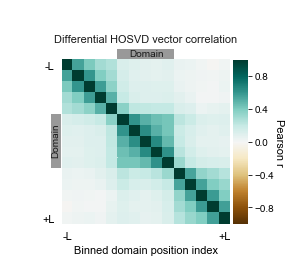

In [8]:
# Figuer 4C: Bin the differential vector signal across contact domains
# and calculate the correlation between the bins
domain_boundary_corr = bin_contact_domains(U_diff, cd_bed)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]

## Colors to use for indicating where the domain is
row_colors = ['w' for i in range(5)]
row_colors += [(0.6, 0.6, 0.6) for i in range(5)]
row_colors += ['w' for i in range(5)]

## Plot the heatmap of the correlation
g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(4,4), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('Differential HOSVD vector correlation', fontsize=11, pad=17)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-15.5, 1.038),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.3, -0.169),
                       color='k', fontsize=10, rotation=90)


g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False,
                         top=False, left=False, labelbottom=True)
labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L' # L indicates the width of the domain
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()
g.savefig(output_dir + 'figures/figure4_panels/' + file_prefix +
          '_panelC_differential_domain_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

In [9]:
# Randomly shuffle the contact domain locations around 
# the corresponding chromosome. Some restrictions are
# applied to the resulting location of the shuffled
# domains to ensure there is still a domain width around
# each of the domains

cd_bed_permute = [[] for c in range(len(chr_list))]
for c, chrom in enumerate(chr_list):
    for cd in cd_bed[c]:
        L = int((cd[2] - cd[1])/2000)
        r_start = np.random.randint(L, math.floor(chr_length[chrom]/2000)-2*L, 1)[0]
        cd_bed_permute[c].append([cd[0], r_start*2000, (r_start+L)*2000])

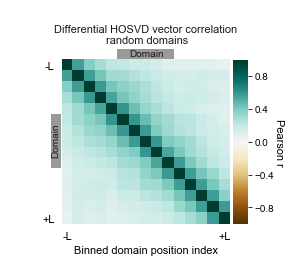

In [10]:
# Figure 4D: HOSVD location vector correlation for the 
# randomly permuted domains

domain_boundary_corr = bin_contact_domains(U_diff, cd_bed_permute)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]

g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(4,4), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('Differential HOSVD vector correlation\n random domains',
                       fontsize=11, pad=16)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-15.5, 1.038),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.3, -0.169),
                       color='k', fontsize=10, rotation=90)

g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False,
                         top=False, left=False, labelbottom=True)

labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L'
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()

g.savefig(output_dir + 'figures/figure4_panels/' + file_prefix +
          '_panelD_differential_shuffled_domain_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

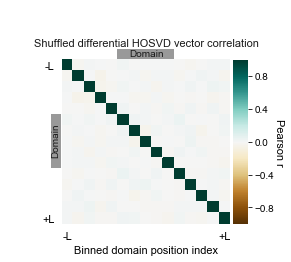

In [11]:
# Figure 4E: Shuffle the components of the differential signal
# vector and compute the correlation between bins within and 
# extending one contact domain width around each domain. The
# contact domains are held fixed at the true locations
U_shuffle = np.copy(U_diff)
np.random.shuffle(U_shuffle)
domain_boundary_corr = bin_contact_domains(U_shuffle, cd_bed)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]
del U_shuffle

## Plot the heatmap of the correlation
g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(4,4), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('Shuffled differential HOSVD vector correlation', fontsize=11, pad=13)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-15.5, 1.038),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.3, -0.169),
                       color='k', fontsize=10, rotation=90)


g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False,
                         top=False, left=False, labelbottom=True)
labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L' # L indicates the width of the domain
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()

g.savefig(output_dir + 'figures/figure4_panels/' + file_prefix +
          '_panelE_differential_shuffled_vector_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

In [12]:
# Repeat the contact domain correlation analysis for the HOSVD 
# location vector specifying the differences between MED12-mut
# and MED12-wt leiomyomas

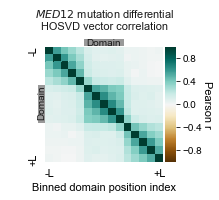

In [13]:
# Figure S4E: Correlation of the vector specifying epigenetic alterations
# between MED12-mut and MED12-wt leiomyomas across the contact domains
domain_boundary_corr = bin_contact_domains(U_MED12_diff, cd_bed)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]
        
g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(2.8, 2.8), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('$\it{MED12}$ mutation differential\nHOSVD vector correlation', fontsize=11, pad=17)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-16.65, 1.012),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.5, -0.23),
                       color='k', fontsize=10, rotation=90)

g.ax_heatmap.yaxis.tick_left()

g.ax_heatmap.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    labelbottom=True)

labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L'
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()

g.savefig(output_dir + 'figures/figureS4_panels/' + file_prefix +
          '_panelE_MED12_differential_domain_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

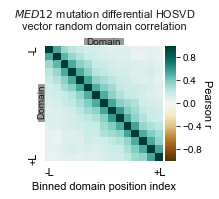

In [14]:
# Figure S4F: Correlation of the vector specifying epigenetic alterations
# between MED12-mut and MED12-wt leiomyomas across randomly shuffled
# contact domains
domain_boundary_corr = bin_contact_domains(U_MED12_diff, cd_bed_permute)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]

g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(2.8,2.8), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('$\it{MED12}$ mutation differential HOSVD\nvector random domain correlation',
                       fontsize=11, pad=16)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-16.65, 1.012),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.5, -0.23),
                       color='k', fontsize=10, rotation=90)

g.ax_heatmap.yaxis.tick_left()

g.ax_heatmap.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    labelbottom=True)

labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L'
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()

g.savefig(output_dir + 'figures/figureS4_panels/' + file_prefix +
          '_panelF_MED12_differential_random_domain_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

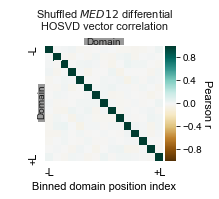

In [15]:
# Figure S4G: Correlation of the vector specifying epigenetic alterations
# between MED12-mut and MED12-wt leiomyomas with randomly shuffled components
# the contact domains are fixed at the true locations
U_shuffle = np.copy(U_MED12_diff)
np.random.shuffle(U_shuffle)
domain_boundary_corr = bin_contact_domains(U_shuffle, cd_bed)
corr_matrix = np.zeros((15,15))
for i in range(15):
    for j in range(i,15):
        corr_matrix[i,j] = scipy.stats.pearsonr(np.array(domain_boundary_corr)[:,i],
                                                np.array(domain_boundary_corr)[:,j])[0]
        corr_matrix[j,i] = corr_matrix[i,j]
del U_shuffle

g = seaborn.clustermap(corr_matrix, row_cluster=False, col_cluster=False,
                       robust=False, row_colors=row_colors, col_colors=row_colors,
                       figsize=(2.8,2.8), vmin=-1.0, vmax=1.0, cmap='BrBG')

g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_ylabel('Pearson r', rotation=270, fontsize=11, labelpad=10)
g.ax_heatmap.set_title('Shuffled $\it{MED12}$ differential\nHOSVD vector correlation',
                       fontsize=11, pad=16)
g.ax_heatmap.set_xlabel('Binned domain position index', fontsize=11)

plt.annotate('Domain', (0.0, 1.0), xytext=(-16.65, 1.012),
                       color='k', fontsize=10)

plt.annotate('Domain', (0.0, 1.0), xytext=(-26.5, -0.23),
                       color='k', fontsize=10, rotation=90)

g.ax_heatmap.yaxis.tick_left()

g.ax_heatmap.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    labelbottom=True)

labels = [item.get_text() for item in g.ax_heatmap.get_yticklabels()]
labels[0] = '-L'
labels[-1] = '+L'
for i in range(len(labels)-2):
    labels[i+1] = ''
g.ax_heatmap.set_yticklabels(labels, fontsize=11)
g.ax_heatmap.set_xticklabels(labels, fontsize=11)
plt.show()

g.savefig(output_dir + 'figures/figureS4_panels/' + file_prefix +
          '_panelG_shuffled_MED12_differential_domain_correlation_' + date + '.png',
          dpi=300, bbox_inches='tight')

In [16]:
# Find contact domains with epigenetic alterations between
# uterine leiomyoma and myometrium.

In [17]:
# For each contact domain, calculate the sum of the HOSVD
# location vector components for all genomic bins passing
# the significance threshold within the domain.
cd_change = [[] for c in range(len(chr_list))]
chr_shift = 0
for c, chrom in enumerate(chr_list):
    for cd in cd_bed[c]:
        # Get the indices for the first and last genomic bin
        # lying completely within the domain.
        start = math.ceil(cd[1]/2000)
        end = math.floor(cd[2]/2000)
        net = 0
        for l in range(start, end):
            # Only consider the bin if it passes the threshold
            if(abs(U_diff[chr_shift + l]) > cut):
                net += U_diff[chr_shift + l]
        cd_change[c].append(net)
    # The chr_shift adjusts the indexing for each chromosome
    chr_shift += math.ceil(chr_length[chrom]/2000) + 1

In [18]:
# Need to flatten the array for plotting
flat_cd_change = []
flat_cd_index = {}
for c in range(len(chr_list)):
    for l in range(len(cd_change[c])):
        flat_cd_change.append(cd_change[c][l])
        flat_cd_index[len(flat_cd_change)-1] = (c,l)
        
flat_cd_change = np.array(flat_cd_change)

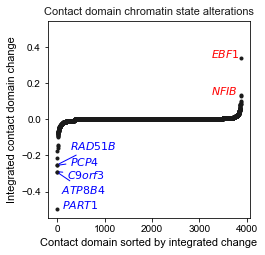

In [19]:
# Figure 4F: Contact domain alterations. Plot the net differential
# HOSVD location vector signal for each contact domain. The gene 
# names were added manually by looking at the top few differential
# regions and finding the most differentially expressed gene within
# each region.

fig, ax = plt.subplots(1,1,figsize=(3.62, 3.62))
plt.plot(np.sort(flat_cd_change),'k.')
x = [float(i) for i in range(len(flat_cd_change))]
y = np.sort(flat_cd_change)

ax.annotate('$\it{EBF1}$', (x[-1],y[-1]), xytext=((1-0.16)*x[-1],y[-1]),
            color=(1,0,0,1), fontsize=11)
ax.annotate('$\it{NFIB}$', (x[-2],y[-2]), xytext=((1-0.16)*x[-2],y[-2]),
            color=(1,0,0,1), fontsize=11)

ax.annotate('$\it{PART1}$', (x[0],y[0]), xytext=(100, y[0]),
            color=(0,0,1,1), fontsize=11)

ax.annotate('$\it{ATP8B4}$', (x[1],y[1]), xytext=(x[1] + 80, y[1]*(1+0.41)),
            color=(0,0,1,1), fontsize=11, arrowprops={'arrowstyle': '-','color':(0,0,1,1)})

ax.annotate('$\it{C9orf3}$', (x[2],y[2]), xytext=(x[2] + 200, y[2]*(1+0.13)),
            color=(0,0,1,1), fontsize=11, arrowprops={'arrowstyle': '-','color':(0,0,1,1)})

ax.annotate('$\it{PCP4}$', (x[3],y[3]), xytext=(x[3] + 265, y[3]*(1+0.0)),
            color=(0,0,1,1), fontsize=11, arrowprops={'arrowstyle': '-','color':(0,0,1,1)})

ax.annotate('$\it{RAD51B}$', (x[4],y[4]), xytext=(x[4] + 275, y[4]*(1-0.32)),
            color=(0,0,1,1), fontsize=11, arrowprops={'arrowstyle': '-','color':(0,0,1,1)})

plt.ylim((-(1+.1)*max(np.abs(flat_cd_change)), (1+.1)*max(np.abs(flat_cd_change))))
ax.set_ylabel('Integrated contact domain change', fontsize=11)
ax.set_xlabel('Contact domain sorted by integrated change', fontsize=11)
plt.title('Contact domain chromatin state alterations', fontsize=11)

plt.savefig(output_dir + 'figures/figure4_panels/panelF_integrated_domain_change_' + date + '.png',
            dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Contact domain index')

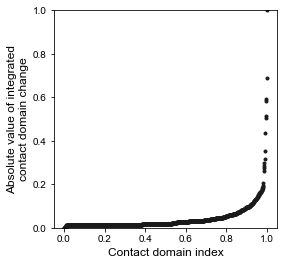

In [20]:
# Select the contact domains with non-zero change and 
# take the absoule value. Scale and shift so that the 
# x and y axis range from 0-1. 

sorted_nonzero_cd = np.sort(np.abs(flat_cd_change[np.where(flat_cd_change != 0.0)[0]]))
sorted_nonzero_cd = sorted_nonzero_cd - min(sorted_nonzero_cd)
sorted_nonzero_cd = sorted_nonzero_cd/max(sorted_nonzero_cd)

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(np.linspace(0, 1, num=len(np.where(flat_cd_change != 0.0)[0])),
         sorted_nonzero_cd, 'k.')

plt.ylim((0.0,1.0))
ax.set_ylabel('Absolute value of integrated\ncontact domain change', fontsize=12)
ax.set_xlabel('Contact domain index', fontsize=12)

In [21]:
# Find the x-axis point in the above plot where the line of slope 
# one is tangent to the curve. This amounts to finding the point 
# for which the line passsing through the point with slope 1 has
# the fewest points below the line.

N = len(np.where(np.abs(flat_cd_change) > 0.0)[0])
n_below = [0 for i in range(N)]
for i in range(0,N):
    b = sorted_nonzero_cd[i] - i/N
    for j in range(0,N):
        if( (j-i)/N + sorted_nonzero_cd[i] > sorted_nonzero_cd[j] ):
            n_below[i] += 1
print(N, np.min(n_below), np.argmin(n_below))
b = sorted_nonzero_cd[np.argmin(n_below)] - np.argmin(n_below)/N
print(b)

764 0 712
-0.8176361646617092


Text(0.5, 0, 'Contact domain index')

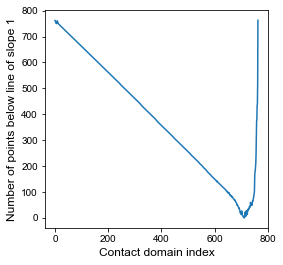

In [22]:
# Visualize the number of points below the line of slope one passing
# through each of the data points. 
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(n_below)
ax.set_ylabel('Number of points below line of slope 1', fontsize=12)
ax.set_xlabel('Contact domain index', fontsize=12)

In [23]:
# Write the contact domains with significant change, where
# a significant change is determined by lying at or above
# the point where the line of slope 1 is tangent.

diff_cds_pos = open(output_dir + 'diff_contact_domains_lower_leio_'+date+'.bed', 'w+')
diff_cds_neg = open(output_dir + 'diff_contact_domains_higher_leio_'+date+'.bed', 'w+')

arg_sorted_cds = np.argsort(np.abs(flat_cd_change))
L = len(flat_cd_change)
thresh = L - (N - np.argmin(n_below))
print(thresh, L)
for i in range(thresh, L):
    bed_index = flat_cd_index[arg_sorted_cds[i]]
    if(flat_cd_change[arg_sorted_cds[i]] > 0.0):
        diff_cds_pos.write("{}\t{}\t{}\n".format(cd_bed[bed_index[0]][bed_index[1]][0],
                                                 cd_bed[bed_index[0]][bed_index[1]][1],
                                                 cd_bed[bed_index[0]][bed_index[1]][2]))
    if(flat_cd_change[arg_sorted_cds[i]] < 0.0):
        diff_cds_neg.write("{}\t{}\t{}\n".format(cd_bed[bed_index[0]][bed_index[1]][0],
                                                 cd_bed[bed_index[0]][bed_index[1]][1],
                                                 cd_bed[bed_index[0]][bed_index[1]][2])) 
diff_cds_pos.close()
diff_cds_neg.close()

3821 3873


In [24]:
# Look for differentially expressed genes in the contact
# domains exhibiting epigenetic alterations

# The gene table can be obtained from the UCSC Table Browser.
# Select the knownGene table for the hg19 genome and select the
# first 5 fields for output.
isoform_file = open('./knownGene_hg19.txt','r')
isoform_table = []
for iso in isoform_file:
    if(iso[0] != '#'):
        isoform_table.append(iso.strip().split('\t')) 
isoform_file.close()

# A function that reads a DESeq2 output file
def readDEFile(DE_file):
    DE_array = []
    DEf = open(DE_file,'r')
    for line in DEf:
        if(line[0] == '#'):
            continue
        l = line.strip().split(',')
        l[0] = l[0].strip().split('"')[1]
        DE_array.append(l)
    DEf.close()
    return DE_array

# Given a gene list and a differential expression table,
# select only the genes passing the provided thresholds
def intersectwDE(gene_list, DE_list, padj, log2FC_cut):
    # pajd is the adjusted p-value threshold 
    # FC_cut is a threshold on the absolute value of the
    # log2FC
    intersect = []
    for gene in gene_list:
        for j in range(len(DE_list)):
            if(DE_list[j][0] == gene):
                if(DE_list[j][6] == 'NA'):
                    continue
                if(float(DE_list[j][6]) < padj and abs(float(DE_list[j][2])) > log2FC_cut ):
                    intersect.append([gene,float(DE_list[j][2])])
                    break
                    
    return intersect

# Get the list of expressed genes to remove lowly expressed
# genes from consideration
expressed_genes_file = open('./expressedGenes_final_any.txt','r')
expressed_genes = []
for line in expressed_genes_file:
    expressed_genes.append(line.strip())

# Read the differential expression file
gene_DE = readDEFile('./leiomyoma_paired_pt_DESeq2_results.csv')

In [25]:
# Get differentially expressed genes for which any isoform 
# overlaps one of the differential contact domains. 
# This is done separately for contact domains with increasing
# and decreasing activating histone marks in leiomyoma

def singleOverlap(region1, region2):
    # Tests for an overlap between the two regions
    # in bed format
    if(region1[0] != region2[0]):
        return False
    elif(region1[1] < region2[2] and region1[2] > region2[1]):
        return True
    else:
        return False
    
diff_cds_high = abf.readBedList(output_dir + 'diff_contact_domains_higher_leio_'+date+'.bed')

cds_high_genes = {}
for region in diff_cds_high:
    cds_high_genes[tuple(region)] = []
    for iso in isoform_table:
        if(singleOverlap(region, [iso[1], int(iso[3]), int(iso[4])])):
            if(iso[-1] not in cds_high_genes[tuple(region)]):
                cds_high_genes[tuple(region)].append(iso[-1])

cds_high_DE_genes = {}
for cd in cds_high_genes:
    cds_high_DE_genes[cd] = intersectwDE(cds_high_genes[cd], gene_DE, 0.01, 0.5)


diff_cds_low = abf.readBedList(output_dir + 'diff_contact_domains_lower_leio_'+date+'.bed')

cds_low_genes = {}
for region in diff_cds_low:
    cds_low_genes[tuple(region)] = []
    for iso in isoform_table:
        if(singleOverlap(region, [iso[1], int(iso[3]), int(iso[4])])):
            if(iso[-1] not in cds_low_genes[tuple(region)]):
                cds_low_genes[tuple(region)].append(iso[-1])

cds_low_DE_genes = {}
for cd in cds_low_genes:
    cds_low_DE_genes[cd] = intersectwDE(cds_low_genes[cd], gene_DE, 0.01, 0.5)

In [26]:
# How many of the differential contact domains contain a gene
# that is differentially expressed in the corresponding direction.

n_cds = len(cds_high_DE_genes)
n_DE_cds = 0
for cd in cds_high_DE_genes:
    for gene in cds_high_DE_genes[cd]:
        if(gene[1] > 0.0):
            n_DE_cds += 1
            break
print('Increasing regions with increasing DE genes: ', n_DE_cds, n_cds)

n_cds = len(cds_low_DE_genes)
n_DE_cds = 0
for cd in cds_low_DE_genes:
    for gene in cds_low_DE_genes[cd]:
        if(gene[1] < 0.0):
            n_DE_cds += 1
            break
print('Decreasing regions with decreasing DE genes: ', n_DE_cds, n_cds)

Increasing regions with increasing DE genes:  23 33
Decreasing regions with decreasing DE genes:  17 19
